In [3]:
from NeuralNetwork import NN, MLP, TinyCNN
from SGD import stochastic_gradient_descent
from SGD import rss, mse
from typing import List
from αEstimator import hill_α_estimator_Bootstrap_mse

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import os, random

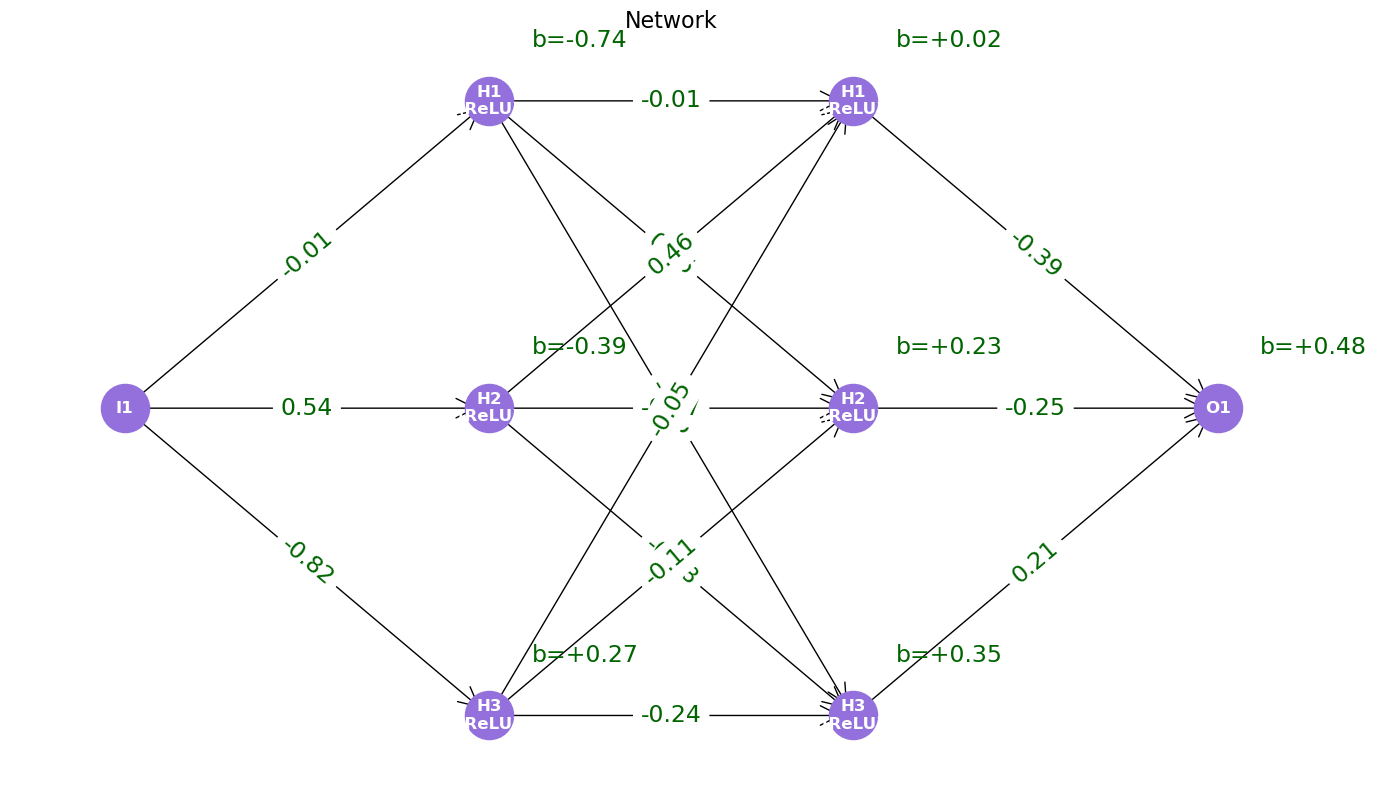

[tensor([[-0.0075],
         [ 0.5364],
         [-0.8230]], requires_grad=True),
 tensor([-0.7359, -0.3852,  0.2682], requires_grad=True),
 tensor([[-0.0114,  0.4578, -0.0512],
         [ 0.1528, -0.1745, -0.1135],
         [-0.5516, -0.3824, -0.2380]], requires_grad=True),
 tensor([0.0214, 0.2282, 0.3464], requires_grad=True),
 tensor([[-0.3914, -0.2514,  0.2097]], requires_grad=True),
 tensor([0.4794], requires_grad=True)]

In [4]:
model1 = MLP(sizes=(1,3,3,1), activation=nn.ReLU, add_softmax=False)
model1.visualize()
model1.get_θ()

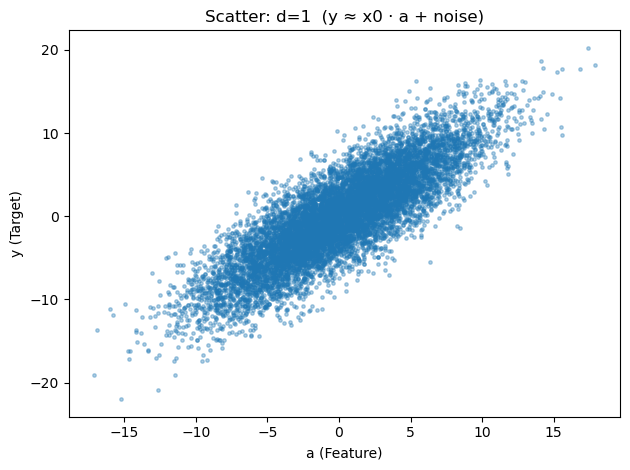

In [15]:
#Synthetical Data for Training of the neural network
n = 10000
sigma_x = 3.0
sigma = 1.0
sigma_y = 3.0
d_input = 2

x0  = torch.normal(0.0, sigma_x, size=(d_input, 1))   
A   = torch.normal(0.0, sigma,   size=(n, d_input))  
eps = torch.normal(0.0, sigma_y, size=(n, 1))        

Y = A @ x0 + eps         
X = A @ x0

plt.figure()
plt.scatter(X, Y, s=6, alpha=0.35)     
plt.xlabel("a (Feature)")
plt.ylabel("y (Target)")
plt.title("Scatter: d=1  (y ≈ x0 · a + noise)")
plt.tight_layout()
plt.show()

In [16]:
X = A @ x0
Y_hat = model1(X).detach().numpy()

In [17]:
#Exogenous variables for SGD
η1, η2, η3, η4, η5 = 0.01, 0.3, 0.1, 0.001, 0.0003
b = 32

## Vorbereitung der SGD-Iterate
Modell wird mit zufälligen Weights initialisiert. 
Der Trainingsdatensatz wird mit dem DGP erstellt. 

Danach wird das Neuronale Netz mit dem SGD trainiert.

Die SGD-Iterate werden in einer Liste gespeichert und die erste Hälfte wird entfernt und nur die letzen 1000 SGD-Iterate gespeichert.

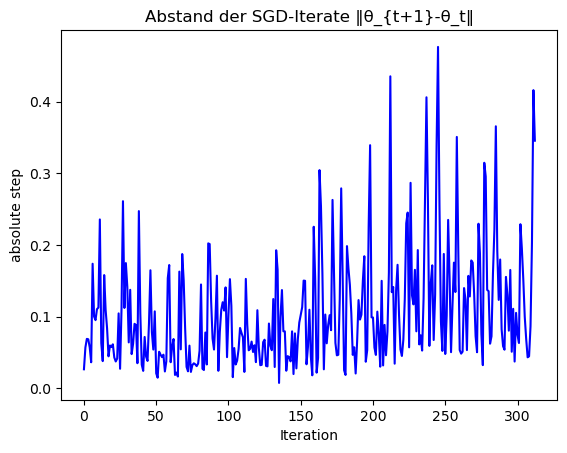

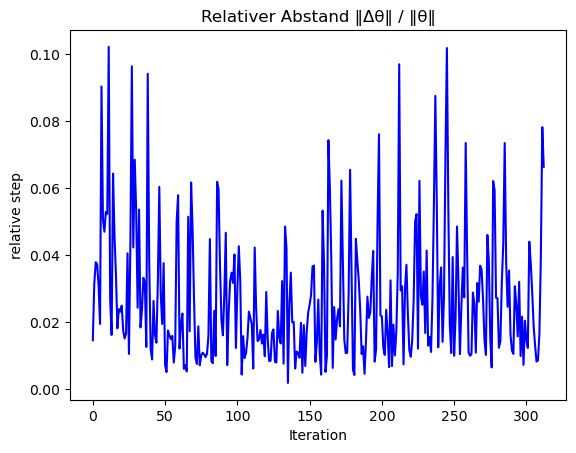

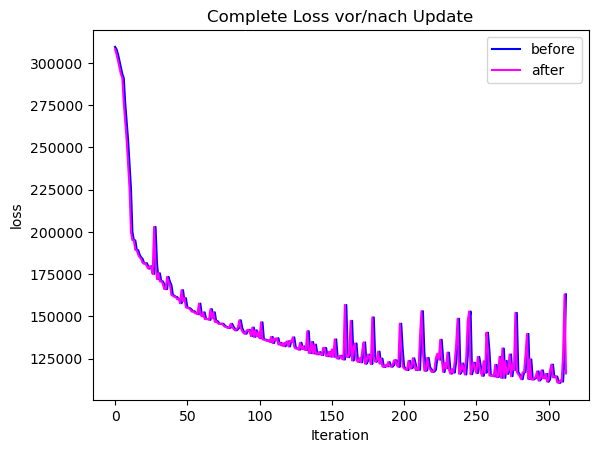

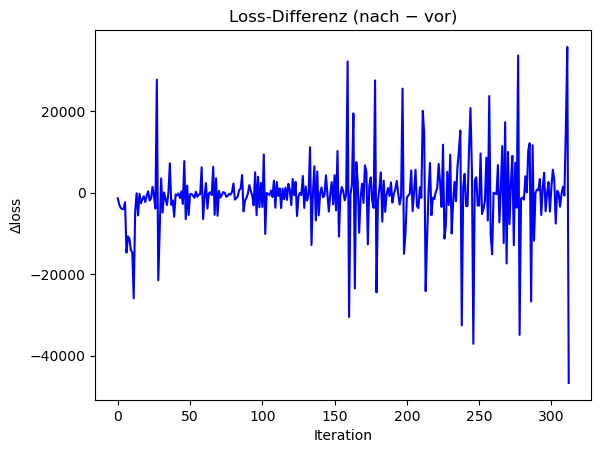

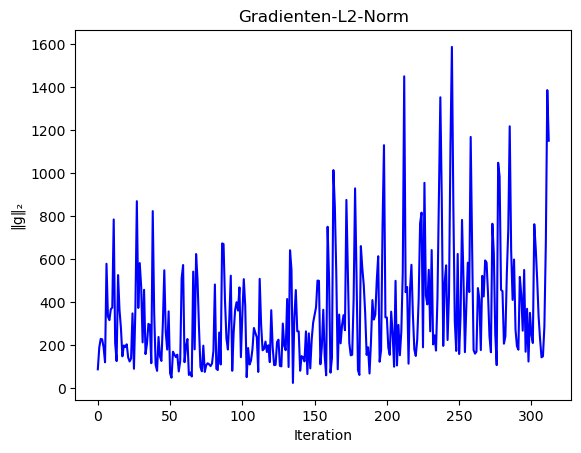

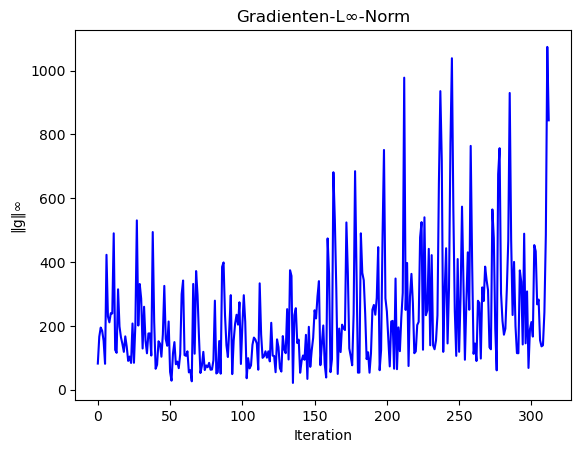

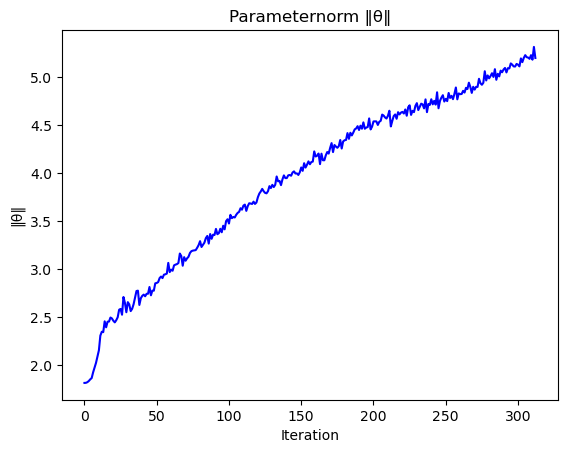

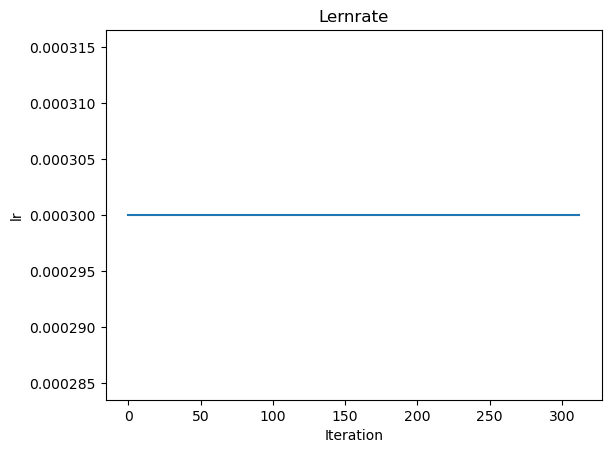

Final Loss(θ0): 309469.3125
Final Loss(θ*): 116339.8828125
Absolute Final Error Reduction: -46732.9765625
Relative Final Error Reduction: -15.10%


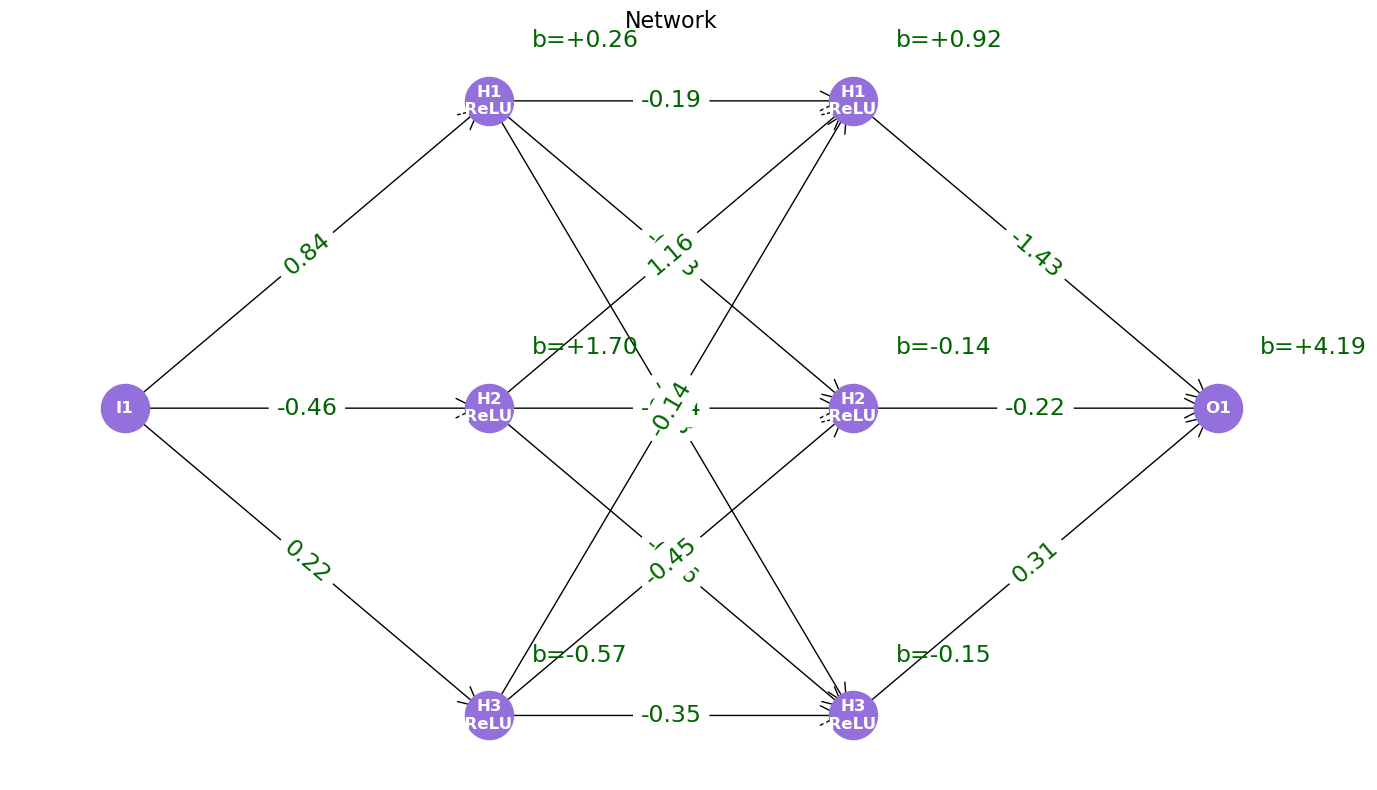

In [18]:
θ0 = model1.get_θ()
training_dataset = list(zip(X,Y))

θ1, θ_iterates, grad_iterates = stochastic_gradient_descent(model1, θ0, training_dataset, rss, η5, b, plot=True)
final_diff = (torch.cat([(c - p).reshape(-1) for p, c in zip(θ0, θ1)])).norm().item()


model1.visualize()
Y_hat = model1(X).detach().numpy()


#Remove the first half of the sgd-iterates, so the focus lies on the 
#iterates that wave around an attractor area.
θ_iterates = θ_iterates[int(len(θ_iterates) / 2):]

## Ansatz 1

In [ ]:
"""
Resets the random seed for new random MLP Generation
and new random Training Dataset Generation
"""
def reseed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Für reproduzierbare CUDA-Kernels (kann minimal langsamer sein):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # Optional (noch strikter, kann Ops verbieten):
    # os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    # torch.use_deterministic_algorithms(True)

"""
Function which takes the configuration parameters of a
SGD-Iterate and returns the Weight Matrices of every layer. 
"""
def extract_WeightMatrices(tensors: List[torch.Tensor]) -> List[float]:
    weight_matrices = []
    for t in tensors:
        if isinstance(t, torch.Tensor) and t.ndim >= 2:
            weight_matrices.append(t.detach().cpu().numpy().astype(float).tolist())
    return weight_matrices

"""
Takes the SGD-Iterates and extracts the Weight Matrices of the first layer.
Calculates the mean of the First Layer Weight Matrices and then centers the Matrix.
"""
def calculate_W1_centered(θ_iterates: List[torch.Tensor]) -> List[List[float]]:
    #Extract the first Layer Weight Matrices
    W1_matrices = []

    for θ in θ_iterates:
        W1_matrices.append(extract_WeightMatrices(θ)[0])

    #Calculate the mean of all the first weight matrices
    W1_mean = (np.array(W1_matrices)).mean(axis=0)

    #Center the W1 Mean Matrix
    W1_last = W1_matrices[-1]
    W1_centered = W1_mean - W1_last
    return W1_centered

"""
"""
def simulate(random_seeds: List[float]) -> List[List[float]]:
    L = 500
    K0 = 0.5
    W1_centered_matrices = []
    for seed in random_seeds:
        #Randomize everything
        reseed(seed)
        
        #New Model
        model = MLP(sizes=(1,3,3,1), activation=nn.ReLU, add_softmax=False)

        #New generated Training Dataset
        x0  = torch.normal(0.0, sigma_x, size=(d_input, 1))   
        A   = torch.normal(0.0, sigma,   size=(n, d_input))  
        eps = torch.normal(0.0, sigma_y, size=(n, 1))        

        Y = A @ x0 + eps         
        X = A @ x0

        training_dataset = list(zip(X,Y))

        #SGD optimization
        θ1, θ_iterates, grad_iterates = stochastic_gradient_descent(model, θ0, training_dataset, rss, η5, b, plot=False)
        θ_iterates = θ_iterates[int(len(θ_iterates) / 2):]
        θ_iterates = θ_iterates[-L:]
        
        W1_centered = calculate_W1_centered(θ_iterates)
        W1_centered_matrices.append(W1_centered)

    return W1_centered_matrices

def project_T(W1_centered_mats, M=15, rng=None):
    rng = np.random.default_rng(rng)
    estimates = []
    T_all = []
    for m in range(M):
        u = rng.normal(size=D); u /= np.linalg.norm(u)
        T = np.empty(R, dtype=float)
        for r, Z in enumerate(W1_centered_matrices):
            z_vec = np.asarray(Z, float).reshape(-1)
            T[r] = abs(u @ z_vec)     # Betrag, KEIN Positiv-Filter
        # Hill + (dein) Bootstrap–MSE-k Auswahl
        alpha_hat, k_star, lo, hi, _ = hill_α_estimator_Bootstrap_mse(T)
        estimates.append((alpha_hat, lo, hi, k_star))
        T_all.append(T)
    return estimates, T_all

def _diag_T(T):
    T = np.asarray(T)
    print("len(T)=", len(T),
          " finite=", np.isfinite(T).sum(),
          " >0=", (T>0).sum(),
          " unique_pos=", np.unique(T[T>0]).size,
          " min_pos=", np.min(T[T>0]) if np.any(T>0) else None,
          " max=", np.nanmax(T))



# fixer Startseed für Reproduzierbarkeit
rng = np.random.default_rng(1338)       
seeds = rng.integers(0, 2**31 - 1, size=120, dtype=np.int64).tolist()

W1_centered_matrices = simulate(seeds)

R = len(W1_centered_matrices)
D = W1_centered_matrices[0].shape[0]
M = 15

#Projections of the First Layer Weight Matrices on a random normalized direction u 
#M random normalized directions u
α_estimates, cis, T_list = [], [], []
rng = np.random.default_rng(rng)
for m in range(M):
    u = rng.normal(size=D); u /= np.linalg.norm(u)
    T = np.empty(R, dtype=float)
    for r, Z in enumerate(W1_centered_matrices):
        z_vec = np.asarray(Z, float).reshape(-1)
        T[r] = abs(u @ z_vec)     

    n_pos = T.size
    n_unique = np.unique(T).size

    if n_pos < 30 or n_unique < 15:
        continue
    
    alpha_hat, k_star, lo, hi, mse = hill_α_estimator_Bootstrap_mse(T, rng=rng)
    α_estimates.append((alpha_hat, lo, hi, k_star))
    cis.append((lo, hi, k_star, mse))
    T_list.append(T)

#for _ in range(M):
#    u = np.random.normal(size=W1_centered_matrices[0].shape)
#    u /= np.linalg.norm(u)
    
#    T = np.squeeze([z.T.dot(u) for z in W1_centered_matrices])
#    T = np.asarray(T, dtype=float)
#    T = T[np.isfinite(T)]
#    T = T[T > 0]
#    n_pos = T.size
#    n_unique = np.unique(T).size
#    
#    if n_pos < 30 or n_unique < 15:
#        continue
#        
#    #_diag_T(T)
#    α_hat, k_star, lo, hi, mse = hill_α_estimator_Bootstrap_mse(T, rng=rng)
#    α_estimates.append(α_hat); 
#    cis.append((lo, hi, k_star, mse))
#    T_list.append(T)


In [ ]:
# ---- Hilfsfunktionen zum robusten Entpacken ----
def to_1d_alpha(alpha_estimates):
    a = np.asarray(alpha_estimates, dtype=float)
    if a.ndim == 1:                 
        return a
    return a[:, 0]                  

def to_lo_hi(cis):
    # erlaubt (lo, hi), (lo, hi, k), (lo, hi, k, mse)
    arr = np.asarray(cis, dtype=float)
    if arr.ndim == 1:
        arr = arr.reshape(-1, 2)
    return arr[:, :2]

alphas = to_1d_alpha(α_estimates)
ci_arr = to_lo_hi(cis)

m = min(len(alphas), len(ci_arr))
alphas = alphas[:m]
lo = ci_arr[:m, 0]
hi = ci_arr[:m, 1]

finite = np.isfinite(alphas) & np.isfinite(lo) & np.isfinite(hi)
alphas = alphas[finite]; lo = lo[finite]; hi = hi[finite]
M_eff = len(alphas)
x = np.arange(1, M_eff+1)

α_median = float(np.nanmedian(alphas))
α_q1, α_q3 = np.nanquantile(alphas, [0.25, 0.75])

fig, ax = plt.subplots()
bp = ax.boxplot(
    alphas,
    patch_artist=True,               
    medianprops=dict(color="black"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    boxprops=dict(edgecolor="black"),
    flierprops=dict(marker="o", markerfacecolor="lightblue", markersize=4, markeredgecolor="black")
)

# Alle Boxen gleich einfärben
for box in bp["boxes"]:
    box.set_facecolor("#add8e6")     
    box.set_alpha(0.8)

ax.set_title("Boxplot mit einheitlicher Farbe")
plt.tight_layout(); plt.show()

yerr_lower = np.clip(alphas - lo, 0, None)
yerr_upper = np.clip(hi - alphas, 0, None)
yerr = np.vstack([yerr_lower, yerr_upper])

plt.figure()
plt.errorbar(x, alphas, yerr=yerr, fmt="o", capsize=4, color="blue")
plt.axhline(2.0, linestyle=":", color="blue")
plt.xlabel("Richtung (Index)")
plt.ylabel("α-Schätzer (mit 95%-CI)")
plt.title("α über Richtungen u (Fehlerbalken = 95%-CI)")
plt.tight_layout()
plt.show()

# Konfidenzintervalle
# Wähle die Richtung, deren α am nächsten am Richtungsmedian liegt:
idx_med = int(np.argmin(np.abs(alphas - α_median)))

T_med = np.asarray(T_list[idx_med], dtype=float)   
# Kein Positiv-Filter; T_med ist bereits |u^T vec(Z_r)| ≥ 0
T_sorted = np.sort(T_med[np.isfinite(T_med)])
sf = 1.0 - np.arange(1, len(T_sorted)+1)/len(T_sorted)

plt.figure()
plt.loglog(T_sorted, sf, color="blue")  

alpha_ref = alphas[idx_med]
if np.isfinite(alpha_ref) and len(T_sorted) > 2:
    
    # Tail-Anker am 90%-Perzentil
    i0 = int(np.ceil(0.90 * len(T_sorted))) - 1
    i0 = max(0, min(i0, len(T_sorted)-1))
    z0 = T_sorted[i0]; S0 = sf[i0]
    z_max = T_sorted[-1]
    if z_max > z0 > 0 and S0 > 0:
        ref_x = np.array([z0, z_max])
        ref_y = S0 * (ref_x / z0) ** (-alpha_ref)
        plt.loglog(ref_x, ref_y, color="red")   

plt.xlabel("|u^T vec(Z)|")
plt.ylabel("Survival 1 - F(z)")
plt.title(f"Tail-Plot (Log-Log) – ref slope ~ z^(-{alpha_ref:.2f})")
plt.tight_layout()
plt.grid(True)
plt.show()

print({
    "M_effective": M_eff,
    "alpha_median": α_median,
    "alpha_IQR": (α_q1, α_q3)
})